In [1]:
# read mds data from file
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn import manifold
import time
import os

In [2]:
X_train_2dims = pd.read_csv("reduceDims/mds2dims_X_train.csv",
                            index_col=False )

In [3]:
print("load finish")

load finish


In [4]:
# remove index column
X_train_2dims.drop(X_train_2dims.columns[0], axis=1, inplace=True)

In [5]:
X_train_2dims[:2]

,dim1,dim2,label
0,5.969745,7.240796,0
1,5.449684,0.982294,0


In [6]:
y = list(X_train_2dims["label"])

In [7]:
y[:2]

[0, 0]

In [8]:
y_true = []
for i in y:
    if i == 0:
        y_true.append(1)
    elif i == 1:
        y_true.append(-1)
    else:
        print("error.....")

In [9]:
X_train_2dims.drop(X_train_2dims.columns[-1], axis=1, inplace=True)

In [10]:
X_train_2dims[:2]

,dim1,dim2
0,5.969745,7.240796
1,5.449684,0.982294


In [12]:
X_train_2dims[:1000].to_csv("./reduceDims/mds2dims_X_train_1000samples.csv", header=None, index=False)

In [13]:
X_test_2dims = pd.read_csv("reduceDims/mds2dims_X_test.csv", index_col=False, header=None)

In [14]:
X_test_2dims[:2]

,0,1
0,324.248009,-389.177698
1,193.976694,267.734475


In [15]:
# lof 的论文的具体算法实现
# https://github.com/damjankuznar/pylof
#!/usr/bin/python
# -*- coding: utf8 -*-
"""
lof
~~~~~~~~~~~~

This module implements the Local Outlier Factor algorithm.

:copyright: (c) 2013 by Damjan Kužnar.
:license: GNU GPL v2, see LICENSE for more details.

"""
from __future__ import division
import warnings

def distance_euclidean(instance1, instance2):
    """Computes the distance between two instances. Instances should be tuples of equal length.
    Returns: Euclidean distance
    Signature: ((attr_1_1, attr_1_2, ...), (attr_2_1, attr_2_2, ...)) -> float"""
    def detect_value_type(attribute):
        """Detects the value type (number or non-number).
        Returns: (value type, value casted as detected type)
        Signature: value -> (str or float type, str or float value)"""
        from numbers import Number
        attribute_type = None
        if isinstance(attribute, Number):
            attribute_type = float
            attribute = float(attribute)
        else:
            attribute_type = str
            attribute = str(attribute)
        return attribute_type, attribute
    # check if instances are of same length
    if len(instance1) != len(instance2):
        raise AttributeError("Instances have different number of arguments.")
    # init differences vector
    differences = [0] * len(instance1)
    # compute difference for each attribute and store it to differences vector
    for i, (attr1, attr2) in enumerate(zip(instance1, instance2)):
        type1, attr1 = detect_value_type(attr1)
        type2, attr2 = detect_value_type(attr2)
        # raise error is attributes are not of same data type.
        if type1 != type2:
            raise AttributeError("Instances have different data types.")
        if type1 is float:
            # compute difference for float
            differences[i] = attr1 - attr2
        else:
            # compute difference for string
            if attr1 == attr2:
                differences[i] = 0
            else:
                differences[i] = 1
    # compute RMSE (root mean squared error)
    rmse = (sum(map(lambda x: x**2, differences)) / len(differences))**0.5
    return rmse

class LOF:
    """Helper class for performing LOF computations and instances normalization."""
    def __init__(self, instances, normalize=True, distance_function=distance_euclidean):
        self.instances = instances
        self.normalize = normalize
        self.distance_function = distance_function
        if normalize:
            self.normalize_instances()

    def compute_instance_attribute_bounds(self):
        min_values = [float("inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * n.inf
        max_values = [float("-inf")] * len(self.instances[0]) #n.ones(len(self.instances[0])) * -1 * n.inf
        for instance in self.instances:
            min_values = tuple(map(lambda x,y: min(x,y), min_values,instance)) #n.minimum(min_values, instance)
            max_values = tuple(map(lambda x,y: max(x,y), max_values,instance)) #n.maximum(max_values, instance)

        diff = [dim_max - dim_min for dim_max, dim_min in zip(max_values, min_values)]
        if not all(diff):
            problematic_dimensions = ", ".join(str(i+1) for i, v in enumerate(diff) if v == 0)
            warnings.warn("No data variation in dimensions: %s. You should check your data or disable normalization." % problematic_dimensions)

        self.max_attribute_values = max_values
        self.min_attribute_values = min_values

    def normalize_instances(self):
        """Normalizes the instances and stores the infromation for rescaling new instances."""
        if not hasattr(self, "max_attribute_values"):
            self.compute_instance_attribute_bounds()
        new_instances = []
        for instance in self.instances:
            new_instances.append(self.normalize_instance(instance)) # (instance - min_values) / (max_values - min_values)
        self.instances = new_instances

    def normalize_instance(self, instance):
        return tuple(map(lambda value,max,min: (value-min)/(max-min) if max-min > 0 else 0,
                         instance, self.max_attribute_values, self.min_attribute_values))

    def local_outlier_factor(self, min_pts, instance):
        """The (local) outlier factor of instance captures the degree to which we call instance an outlier.
        min_pts is a parameter that is specifying a minimum number of instances to consider for computing LOF value.
        Returns: local outlier factor
        Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
        if self.normalize:
            instance = self.normalize_instance(instance)
        return local_outlier_factor(min_pts, instance, self.instances, distance_function=self.distance_function)

def k_distance(k, instance, instances, distance_function=distance_euclidean):
    #TODO: implement caching
    """Computes the k-distance of instance as defined in paper. It also gatheres the set of k-distance neighbours.
    Returns: (k-distance, k-distance neighbours)
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> (float, ((attr_j_1, ...),(attr_k_1, ...), ...))"""
    distances = {}
    for instance2 in instances:
        distance_value = distance_function(instance, instance2)
        if distance_value in distances:
            distances[distance_value].append(instance2)
        else:
            distances[distance_value] = [instance2]
    distances = sorted(distances.items())
    neighbours = []
    [neighbours.extend(n[1]) for n in distances[:k]]
    k_distance_value = distances[k - 1][0] if len(distances) >= k else distances[-1][0]
    return k_distance_value, neighbours

def reachability_distance(k, instance1, instance2, instances, distance_function=distance_euclidean):
    """The reachability distance of instance1 with respect to instance2.
    Returns: reachability distance
    Signature: (int, (attr_1_1, ...),(attr_2_1, ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(k, instance2, instances, distance_function=distance_function)
    return max([k_distance_value, distance_function(instance1, instance2)])

def local_reachability_density(min_pts, instance, instances, **kwargs):
    """Local reachability density of instance is the inverse of the average reachability
    distance based on the min_pts-nearest neighbors of instance.
    Returns: local reachability density
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    reachability_distances_array = [0]*len(neighbours) #n.zeros(len(neighbours))
    for i, neighbour in enumerate(neighbours):
        reachability_distances_array[i] = reachability_distance(min_pts, instance, neighbour, instances, **kwargs)
    if not any(reachability_distances_array):
        warnings.warn("Instance %s (could be normalized) is identical to all the neighbors. Setting local reachability density to inf." % repr(instance))
        return float("inf")
    else:
        return len(neighbours) / sum(reachability_distances_array)

def local_outlier_factor(min_pts, instance, instances, **kwargs):
    """The (local) outlier factor of instance captures the degree to which we call instance an outlier.
    min_pts is a parameter that is specifying a minimum number of instances to consider for computing LOF value.
    Returns: local outlier factor
    Signature: (int, (attr1, attr2, ...), ((attr_1_1, ...),(attr_2_1, ...), ...)) -> float"""
    (k_distance_value, neighbours) = k_distance(min_pts, instance, instances, **kwargs)
    instance_lrd = local_reachability_density(min_pts, instance, instances, **kwargs)
    lrd_ratios_array = [0]* len(neighbours)
    for i, neighbour in enumerate(neighbours):
        instances_without_instance = set(instances)
        instances_without_instance.discard(neighbour)
        neighbour_lrd = local_reachability_density(min_pts, neighbour, instances_without_instance, **kwargs)
        lrd_ratios_array[i] = neighbour_lrd / instance_lrd
    return sum(lrd_ratios_array) / len(neighbours)

def outliers(k, instances, **kwargs):
    """Simple procedure to identify outliers in the dataset."""
    instances_value_backup = instances
    outliers = []
    for i, instance in enumerate(instances_value_backup):
        instances = list(instances_value_backup)
        instances.remove(instance)
        l = LOF(instances, **kwargs)
        value = l.local_outlier_factor(k, instance)
        if value > 1:
            outliers.append({"lof": value, "instance": instance, "index": i})
    outliers.sort(key=lambda o: o["lof"], reverse=True)
    return outliers

In [16]:
lof = LOF(X_train_2dims[:1000].values)

In [17]:
p_value_list = list()
# y_pred = list()
for i in range(100):
    instance = tuple(X_test_2dims.iloc[i])
#     print(instance)
    value = lof.local_outlier_factor(5, instance)
    p_value_list.append(value)

In [18]:
p_value_list[:20]

[154.68874088857166,
 1519.7343790621583,
 1261.2567529520602,
 622.5766379436541,
 822.904289259944,
 1624.4128568725193,
 3156.7879531416547,
 1350.4676026344293,
 61.240135409706696,
 1222.5417593257437,
 333.9165109899988,
 2395.173135327111,
 30.98745572182721,
 443.215807923379,
 1184.4973605290088,
 108.6933843950147,
 796.5830527182145,
 758.1629788251428,
 1099.880422528952,
 118.02224355084127]

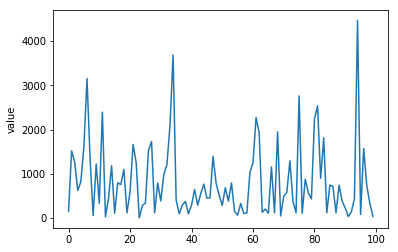

In [19]:
plt.plot(p_value_list)
plt.ylabel('value')
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
"""
The LOF algorithm is an unsupervised outlier detection method
"""
def local_outlier_factor_AD(X):
    clf = LocalOutlierFactor(n_neighbors=20)
    y_pred = clf.fit_predict(X)
    return y_pred

In [21]:
y_pred = local_outlier_factor_AD(X_train_2dims[:1000].values)

In [24]:
y_pred[:100]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1])

In [25]:
list(y_pred).count(-1)

100

In [26]:
from sklearn.metrics import roc_curve, auc

In [27]:
fpr, tpr, _ = roc_curve(y_true[:1000], y_pred)

c:\users\yi\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [33]:
print(y_true)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [28]:
fpr

array([nan, nan])

In [29]:
tpr

array([0.9, 1. ])

In [52]:
# print(p_value_dict)
import csv

In [34]:

# ---------------------------------------------------------------------
def plotOutputKNN(points, sccolors):
    plt.figure(1)
    plt.scatter(points[:, 0], points[:, 1], c=sccolors)
    plt.title("Scatterplot data. Red points are anomalous.")
    plt.show()

In [35]:
def writeOutputKNN(stime, anomList, stringG):
    print(stringG, "kNN has taken %s seconds:" % (time.time() - stime))
    print("The following points are recongnized as anomalies:")
    for p in anomList:
        print("(x, y) equal to:", p[0], p[1])


class fileHandling(object):
    """
    Basic Object Properties for file handling.
    :return: inputData: class variable with the 2D inputdata
    """
    def __init__(self):
#         runDir = os.getcwd()
        
#         with open('eggs.csv', 'wb') as csvfile:
#             spamwriter = csv.writer(csvfile, delimiter=' ',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#         with open('./reduceDims/mds2dims_X_train_1000samples.csv', 'r') as f:
#             reader = csv.reader(f)
# #         fn = os.path.join(runDir, './reduceDims/mds2dims_X_train_1000samples.csv')
# #         ifile = open(fn)

# #         reader = csv.reader(ifile)
        inData = []
        reader = pd.read_csv("./reduceDims/mds2dims_X_train_1000samples.csv")
        for rowindex in range(reader.shape[0]):
            x = float(reader.iloc[rowindex][0])
            y = float(reader.iloc[rowindex][0])
            rowIn = [x, y]
            inData.append(rowIn)
        self.inputData = np.array(inData)
        del inData # is probably quite overkill ..


In [36]:
class kNN(fileHandling):
    '''

    '''
    def __init__(self):
        """

        :rtype: object
        """
        super(kNN,self).__init__()


    def normalizeAndTransInput2D(self, data2handle):
        """
        Normalize and translate 2D input such that max. distance in x- and y- direction
        both equal 1 and left bottom corner starts at (x,y) = (0,0).
        :param: data to normalize
        """

        dd = np.array(data2handle)
        self.xMax = np.absolute(np.max(data2handle[:, 0])) + np.absolute(np.min(data2handle[:, 0]))
        dd[:, 0] = data2handle[:, 0] / self.xMax

        self.yMax = np.absolute(np.max(data2handle[:, 1])) + np.absolute(np.min(data2handle[:, 1]))
        dd[:, 1] = data2handle[:, 1] / self.yMax

        cor = [np.absolute(np.min(dd[:, 0])), np.absolute(np.min(dd[:, 1]))]
        self.cor = np.array(cor)

        self.inputNormT = dd + self.cor
        del dd

    def distanceEuclidean2D(self, p1, p2):
        """
        Compute the Euclidean distance between 2 points.
        :param p1: point one (x, y)
        :param p2: point two (x,y)
        :return: Euclidean distance between 2 points
        """
        #
        # TODO: check if this function should be in the object or out.
        #
        dist = np.sqrt(np.power(np.absolute(p1[0] - p2[0]), 2.) +
                       np.power(np.absolute(p1[1] - p2[1]), 2.) )
        return dist


    def transformPointBack2D(self, pcoord):
        """
        Transform point back to the 'original' space:
        1- translate
        2- multiply with normalizer
        :param: pcoord: point to be transformed
        :return: tpoint: transformed point
        """

        tpoint = pcoord - self.cor
        tpoint[0] = tpoint[0] * self.xMax
        tpoint[1] = tpoint[1] * self.yMax
        return tpoint


    def divide2samples(self, numSamples):
        """
        Devide the input data into numSamples of different samples. The
        :param numSamples: amount of requested different samples
        :return: inputDataSamples
        """
        inputRand = self.inputNormT
        np.random.shuffle(inputRand)
        self.inputDataSamples = np.array_split(inputRand, numSamples)
        self.inputDataSamples = np.array(self.inputDataSamples)


    def distanceKNN(self, pCheck, pTrain, k):
        """
        Find the distance to the k Nearest Neighbours.
        Method utilizes:
         -/ distanceEuclidean2D.
        :param pCheck: point to check
        :param pTrain: dataset to compare with
        :param k: number of nearest neighbours
        :return: distKNN: array with distances to the k Nearest Neighbours
        """
        dList = []
        for p in pTrain:
            dList.append(self.distanceEuclidean2D(pCheck, p))
        dList = np.array(dList)
        dList = np.sort(dList)
        if (dList[0] == 0):
            distKNN = dList[1:k+1]
        else:
            distKNN = dList[:k]
        del dList
        return distKNN

In [37]:
# -----------------------------------------------------------------------------
def kNNstraightforward(k, d):
    """
    Straighforward application of KNN algorithm to identify the anomalous points.
    :param k: value of k for the k nearest neighbour
    :param d: threshold value for distance to consider a point anomalous (d is specified in normalized space)
    :return: the anomalous points, a score list and the input data
    """

    # 0. initiate instance of kNN classe
    anomKNN = kNN()

    # 1. normalize and translate 2D input data
    anomKNN.normalizeAndTransInput2D(anomKNN.inputData)

    # 2.0 find the averaged distance to the k Nearest Neighbours
    # 2.1 find the anomalies: when averaged distance is larger and d
    # 2.2 make an anomaly score
    # TODO: decide whether loop below should be in kNNfunctions - and clean up accordingly
    sList = []
    anomalyList = []
    for tp in anomKNN.inputNormT:
        dist2neighbours = anomKNN.distanceKNN(tp, anomKNN.inputNormT, k)
        sList.append(np.mean(dist2neighbours))
        if (np.mean(dist2neighbours) > d):

            # transform back to normal space to present results
            tpBack = anomKNN.transformPointBack2D(tp)
            anomalyList.append(tpBack)

    anomalyList = np.array(anomalyList)
    sList = np.array(sList)

    # 3. use the averaged distance as score in a scatter plot
    scorecolors = ['red' if value > d else 'blue' for value in sList]

    return anomKNN.inputData, scorecolors, anomalyList


Straightforward kNN has taken 23.133944034576416 seconds:
The following points are recongnized as anomalies:


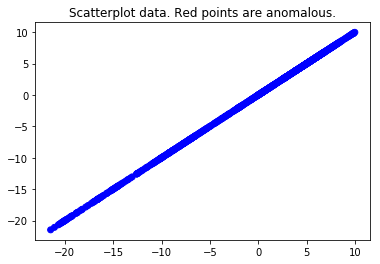

In [38]:
start_time = time.time()
inputD, scoreC,  anomalyList = kNNstraightforward(10, 10)

# 1.2 Present results
writeOutputKNN(start_time, anomalyList, 'Straightforward')
plotOutputKNN(inputD, scoreC)

In [39]:
anomalyList

array([], dtype=float64)

In [40]:
# scoreC
inputD

array([[  5.44968364,   5.44968364],
       [  6.04953984,   6.04953984],
       [  7.20450616,   7.20450616],
       ...,
       [-15.08805674, -15.08805674],
       [ -5.29549963,  -5.29549963],
       [  3.72405219,   3.72405219]])

In [83]:
# we should normalize the data before I input the X_train ??
